In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

# %matplotlib inline

In [2]:
class Agent():
    def __init__(self, x=0.0, y=0.0, vx=0.0, vy=0.0, v_min=0.0, v_max=10.0, psi=0.0):
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.v_min = v_min
        self.v_max = v_max
        self.psi = psi
        
    def update(self, ax=0.0, ay=0.0, vpsi=0.0, dt=0.1):
        # Increment velocity
        self.vx += ax * dt
        self.vy += ay * dt
        
        # Limit velocity
        v_norm = np.sqrt(self.vx**2 + self.vy**2)
        if v_norm < self.v_min:
            self.vx = self.vx * self.v_min / v_norm
            self.vy = self.vy * self.v_min / v_norm
        elif v_norm > self.v_max:
            self.vx = self.vx * self.v_max / v_norm
            self.vy = self.vy * self.v_max / v_norm
                
        # Increment position
        self.x += self.vx * dt
        self.y += self.vy * dt
        
        # Increment heading
        self.psi += vpsi * dt
        
def agent_marker(angle):
    a = np.array([[-1.0,-1.0],
                  [-0.5, 0.0],
                  [-1.0, 1.0],
                  [ 1.0, 0.0]])
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle), np.cos(angle)]])
    return R.dot(a.T).T  

def plot_agent(ax, agent, **args):
    return ax.plot([agent.x], [agent.y], marker=agent_marker(agent.psi), **args)[0]

In [3]:
class Line:
    def __init__(self, 
                 point=np.array([0.0 ,0.0, 0.0]), 
                 axis=np.array([1.0, 0.0, 0.0])):
        self.point = point
        self.axis = axis / np.linalg.norm(axis)
    
    def closest_point(self,
                      point=np.array([0.0, 0.0, 0.0])):
        # ((o + x * a) - p) . a = 0
        # x.a^2 = p.a - o.a
        return self.point + (point - self.point).dot(self.axis) * self.axis

In [4]:
class Vector_field_line:
    def __init__(self,
                 line=Line(),
                 v_c=1.0,
                 k_n=1.0,
                 k_t=1.0):
        self.line = line
        self.v_c = v_c
        self.k_n = k_n
        self.k_t = k_t
        
    def compute_both(self, point=np.array([0.0, 0.0, 0.0])):
        # Closest point on line
        p_line = self.line.closest_point(point)
        
        # Normal unit vector
        u_n = (p_line - point)
        dist = np.linalg.norm(u_n)
        u_n = u_n / dist
        
        # Normal component
        v_n = min(self.v_c, (self.k_n * dist)) * u_n
        
        # Tangent component
        v_t = (self.v_c * 1.0 / (1.0 + dist * self.k_t)) * self.line.axis
        
        return v_n, v_t
    
    def compute(self, point=np.array([0.0, 0.0, 0.0])):
            v_n, v_t = self.compute_both(point)
            return v_n + v_t

In [158]:
class Circle:
    def __init__(self, 
                 center=np.array([1.0, 0.0, 0.0]), 
                 axis=np.array([0.0, 0.0, 1.0]), 
                 radius=0.5):
        self.center = center
        self.axis = axis / np.linalg.norm(axis)
        self.radius = radius
    
    def closest_point(self, point=np.array([0.0, 0.0, 0.0])):
        cp = point - self.center
        cp_proj = cp - cp.dot(self.axis) * self.axis
        dist = np.linalg.norm(cp_proj)
        return self.center + self.radius * cp_proj / dist

In [159]:
class Vector_field_circle:
    def __init__(self,
                 circle=Circle(),
                 v_c=1.0,
                 k_n=1.0,
                 k_t=1.0):
        self.circle = circle
        self.v_c = v_c
        self.k_n = k_n
        self.k_t = k_t
        
    def compute_both(self, point=np.array([0.0, 0.0, 0.0])):
        # Closest point on circle
        p_circle = self.circle.closest_point(point)
        
        # Normal unit vector
        u_n = (p_circle - point)
        dist = np.linalg.norm(u_n)
        u_n = u_n / dist
        
        # Normal component
        v_n = min(self.v_c, (self.k_n * dist)) * u_n
        
        # Tangent unit vector
        u_t = np.cross(self.circle.center - p_circle, self.circle.axis)
        u_t = u_t / np.linalg.norm(u_t)
        
        # Tangent component
        v_t = (self.v_c * 1.0 / (1.0 + dist * self.k_t)) * u_t
        
        return v_n, v_t
    
    def compute(self, point=np.array([0.0, 0.0, 0.0])):
            v_n, v_t = self.compute_both(point)
            return v_n + v_t

In [160]:
# Plotting functions
def plot_line(ax, line, **args):
    t = np.linspace(-2.0, 2.0, 50)
    ax.plot(line.point[0] + t * line.axis[0],
            line.point[1] + t * line.axis[1],
            color='black',
            **args)

def plot_circle(ax, circle, **args):
    t = np.linspace(0, 2 * np.pi, 50)
    return ax.plot(circle.center[0] + circle.radius * np.cos(t),
            circle.center[1] + circle.radius * np.sin(t),
            color='black',
            **args)

def plot_vector_field(ax, 
                      field, 
                      grid=np.array([[x, y, 0.0]
                                     for x in np.linspace(-1.0, 1.0, 25)
                                     for y in np.linspace(-1.0, 1.0, 25)]),
                     component='both',
                     **args):
    
    if component == 'normal':
        vector = np.array([field.compute_both(point)
                           for point in grid])[:, 0, :]
    elif component == 'tangential':
        vector = np.array([field.compute_both(point)
                           for point in grid])[:, 1, :]
    elif component == 'both':
        vector = np.array([field.compute(point)
                           for point in grid])
        
    return ax.quiver(grid[:, 0], grid[:, 1],
                     vector[:, 0], vector[:, 1],
                     pivot='mid',
                     angles='xy',
                     cmap=mpl.cm.Greys,
                     **args)



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


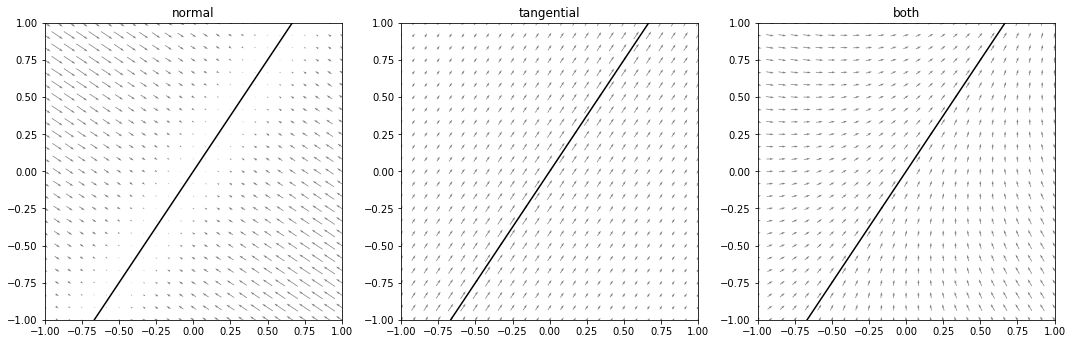

In [161]:
# Example with line 
line = Line(point=np.array([0.0, 0.0, 0.0]),
            axis=np.array([1.0, 1.5, 0.0]))
field = Vector_field_line(line=line)

# Prepare figure
fig, axes = plt.subplots(1, 3, figsize=[15, 5])
for ax in axes:
    ax.axis('square')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])

for ax, component in zip(axes, ['normal', 'tangential', 'both']):
    ax.set_title(component)
    
    # Plot line
    plot_line(ax, line)
    
    # Plot field
    plot_vector_field(ax, field, component=component, alpha=0.5)
    
fig.tight_layout()
plt.show()
fig.savefig('vector_field_line.png', dpi=300)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


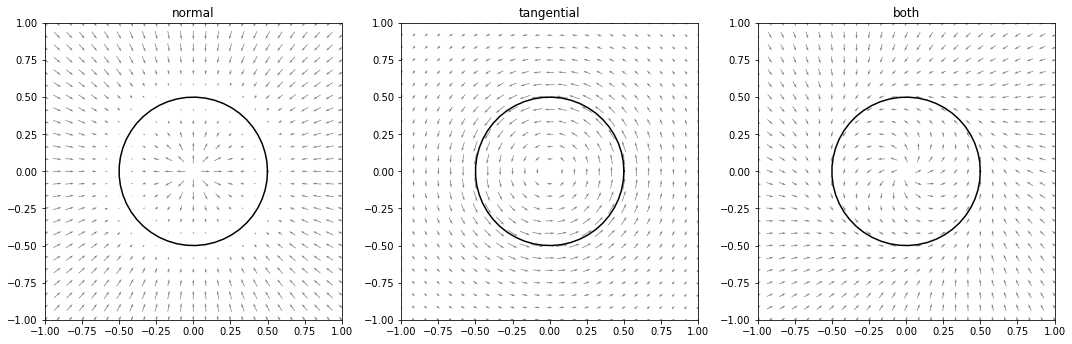

In [164]:
# Example with circle
circle = Circle(center=np.array([0.0, 0.0, 0.0]),
                axis=np.array([0.0, 0.0, 1.0]),
                radius=0.5)
field = Vector_field_circle(circle=circle,
                            k_n=3.0,
                            k_t=3.0)
    
# Prepare figure
fig, axes = plt.subplots(1, 3, figsize=[15, 5])
for ax in axes:
    ax.axis('square')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])

for ax, component in zip(axes, ['normal', 'tangential', 'both']):
    ax.set_title(component)
    
    # Plot circle
    plot_circle(ax, circle)
    
    # Plot field
    plot_vector_field(ax, field, component=component, alpha=0.5)
    
fig.tight_layout()
plt.show()
# fig.savefig('vector_field_circle.png', dpi=300)

In [163]:
# Initialize an agent
agent = Agent(x=-1.0, y=0.0,
              vx=5.0, vy=0.0)

# Timing
dt = 0.05
n_steps = 150

# Prepare trajectory
trajectory = np.zeros([n_steps, 3])

# Update agents state
for k in range(n_steps):       
    # Vector field
    accel = 5.0 * (field.compute(point=np.array([agent.x, agent.y, 0.0])) - np.array([agent.vx, agent.vy, 0.0]))
    
    # Update agent state
    agent.update(ax=accel[0], ay=accel[1], dt=dt)

    # coordinated turn
    agent.psi = np.arctan2(agent.vy, agent.vx)

    # save state
    trajectory[k] = [agent.x, agent.y, agent.psi]

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [89]:
# Animated plot
fig, ax = plt.subplots(1, 1, figsize=[7, 7])
ax.axis('square')
ax.set_xlim([-1.0, 1.0])
ax.set_ylim([-1.0, 1.0])

# Plot circle
plot_circle(ax, circle)
# plot_line(ax, line)

# Plot field
plot_vector_field(ax, field, component=component, alpha=0.5)

# Trajectories - to be animated
lines, = ax.plot(trajectory[:, 0], 
                trajectory[:, 1], 
                alpha=0.5,
                color='C0')

# Agent marker - to be animated
marker = plot_agent(ax, 
                    Agent(x=trajectory[0, 0], y=trajectory[0, 1], psi=trajectory[0, 2]), 
                    markersize=30, 
                    alpha=1.0)

# animate function
def animate(i):
    # Update trails
    start_i = 0
    lines.set_data(trajectory[start_i:i, 0].T, 
                  trajectory[start_i:i, 1].T)
    # Update markers
    marker.set_data(trajectory[i, 0], 
                    trajectory[i, 1])
    marker.set_marker(agent_marker(trajectory[i, 2]))

    return (lines, marker)

anim = animation.FuncAnimation(fig, animate, init_func=None,
                               frames=n_steps, 
                               interval=20, blit=True)

plt.close(fig)

anim

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [90]:
# anim.save('vector_field_line_300dpi.mp4', dpi=300)
anim.save('vector_field_circle_300dpi.mp4', dpi=300)

In [219]:
class Navigation:
    def __init__(self, 
                 items=[{'field': Vector_field_line(line=Line(point=np.array([-1.5, 1.0, 0.0]), axis=np.array([0.0, -1.0, 0.0]))), 
                         'end': Line(point=np.array([-1.5, -1.0, 0.0]), axis=np.array([0.0, -1.0, 0.0]))},
                        {'field': Vector_field_circle(circle=Circle(center=np.array([-1.0, -1.0, 0.0]))), 
                         'end': Line(point=np.array([-1.0, -1.5, 0.0]), axis=np.array([1.0, 0.0, 0.0]))},
                        {'field': Vector_field_line(line=Line(point=np.array([-1.0, -1.5, 0.0]), axis=np.array([1.0, 0.0, 0.0]))), 
                         'end': Line(point=np.array([1.0, -1.5, 0.0]), axis=np.array([1.0, 0.0, 0.0]))},
                        {'field': Vector_field_circle(circle=Circle(center=np.array([1.0, -1.0, 0.0]))), 
                         'end': Line(point=np.array([1.5, -1.0, 0.0]), axis=np.array([0.0, 1.0, 0.0]))},
                        {'field': Vector_field_line(line=Line(point=np.array([1.5, -1.0, 0.0]), axis=np.array([0.0, 1.0, 0.0]))), 
                         'end': Line(point=np.array([1.5, 1.0, 0.0]), axis=np.array([0.0, 1.0, 0.0]))},
                        {'field': Vector_field_circle(circle=Circle(center=np.array([1.0, 1.0, 0.0]))), 
                         'end': Line(point=np.array([1.0, 1.5, 0.0]), axis=np.array([-1.0, 0.0, 0.0]))},
                        {'field': Vector_field_line(line=Line(point=np.array([-1.0, 1.5, 0.0]), axis=np.array([-1.0, 0.0, 0.0]))), 
                         'end': Line(point=np.array([-1.0, 1.5, 0.0]), axis=np.array([-1.0, 0.0, 0.0]))},
                        {'field': Vector_field_circle(circle=Circle(center=np.array([-1.0, 1.0, 0.0]))), 
                         'end': Line(point=np.array([-1.5, 1.0, 0.0]), axis=np.array([0.0, -1.0, 0.0]))}]
                ):
        self.items = items
        self.index = 0

    def update(self, agent):
        agent_pos = np.array([agent.x, agent.y, 0.0])
        end_pos = self.current()['end'].point
        end_axis = self.current()['end'].axis
        if ((agent_pos - end_pos).dot(end_axis) > 0.0):
            self.index = min((self.index + 1), len(self.items) - 1)
    
    def current(self):
        return self.items[self.index]

In [243]:
# Initialize an agent
agent = Agent(x=-2.0, y=0.0,
              vx=0.0, vy=0.0)

# Vector field navigation
navigation = Navigation()

# Timing
dt = 0.05
n_steps = 300

# Prepare trajectory
trajectory = np.zeros([n_steps, 3])

# Update agents state
for k in range(n_steps):
    # Navigation
    navigation.update(agent)
    
    # Vector field
    accel = 20.0 * (navigation.current()['field'].compute(point=np.array([agent.x, agent.y, 0.0])) - np.array([agent.vx, agent.vy, 0.0]))
    
    # Update agent state
    agent.update(ax=accel[0], ay=accel[1], dt=dt)

    # coordinated turn
    agent.psi = np.arctan2(agent.vy, agent.vx)

    # save state
    trajectory[k] = [agent.x, agent.y, agent.psi]

In [245]:
# Animated plot
fig, ax = plt.subplots(1, 1, figsize=[15, 15])
ax.axis('square')
ax.set_xlim([-2.0, 2.0])
ax.set_ylim([-2.0, 2.0])

# Plot circles
plot_circle(ax, Circle(center=np.array([-1.0, -1.0, 0.0])), alpha=0.5)
plot_circle(ax, Circle(center=np.array([-1.0,  1.0, 0.0])), alpha=0.5)
plot_circle(ax, Circle(center=np.array([ 1.0,  1.0, 0.0])), alpha=0.5)
plot_circle(ax, Circle(center=np.array([ 1.0, -1.0, 0.0])), alpha=0.5)

# Re-initialize navigation
navigation.index = 0

# Field - to be animated
grid = np.array([[x, y, 0.0] 
                for x in np.linspace(-2.0, 2.0, 20) 
                for y in np.linspace(-2.0, 2.0, 20)])
quiver = plot_vector_field(ax, 
                           navigation.current()['field'], 
                           color='C{}'.format(i),
                           grid=grid)

# Trajectory - to be animated
lines, = ax.plot(trajectory[:1, 0], trajectory[:1, 1])

# Agent marker - to be animated
marker = plot_agent(ax, 
                    Agent(x=trajectory[0, 0], y=trajectory[0, 1], psi=trajectory[0, 2]), 
                    markersize=30, 
                    alpha=1.0,
                    color='C0')

# animate function
def animate(i, fargs):
    # Update trails
    start_i = 0
    lines.set_data(trajectory[start_i:i, 0].T, 
                   trajectory[start_i:i, 1].T)
    
    # Update markers
    marker.set_data(trajectory[i, 0], 
                    trajectory[i, 1])
    marker.set_marker(agent_marker(trajectory[i, 2]))

    agent.x = trajectory[i, 0]
    agent.y = trajectory[i, 1]
    navigation.update(agent)
    vectors = np.array([navigation.current()['field'].compute(point=point)
                        for point in grid])
#     quiver.set_UVC(vectors[:, 0], vectors[:, 1])
    fargs.set_UVC(vectors[:, 0], vectors[:, 1])
    
    return (quiver, lines, marker)

anim = animation.FuncAnimation(fig, animate, init_func=None, fargs=(quiver,),
                               frames=n_steps, 
                               interval=20, blit=False)

plt.close(fig)

anim


In [242]:
anim.save('vector_field_navigation_300dpi.mp4', dpi=300)